In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from arch.unitroot import ADF, KPSS, PhillipsPerron
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [55]:
# Carga de datos
TipoCambio = pd.read_excel("C:/Users/snin2/Desktop/Tensorflow/Tipo de Cambio MXN 2023.xlsx")
TipoCambio.rename(columns={'Date': 'Fecha', 'Close': 'TC'}, inplace=True)

# Transformación de datos: logaritmo
TC_log = np.log(TipoCambio['TC'])

# Graficas

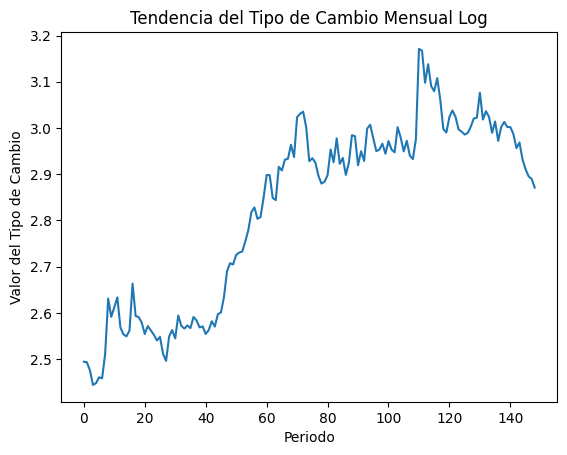

In [56]:
TC_log.plot()
plt.title('Tendencia del Tipo de Cambio Mensual Log')
plt.xlabel('Periodo')
plt.ylabel('Valor del Tipo de Cambio')
plt.show()

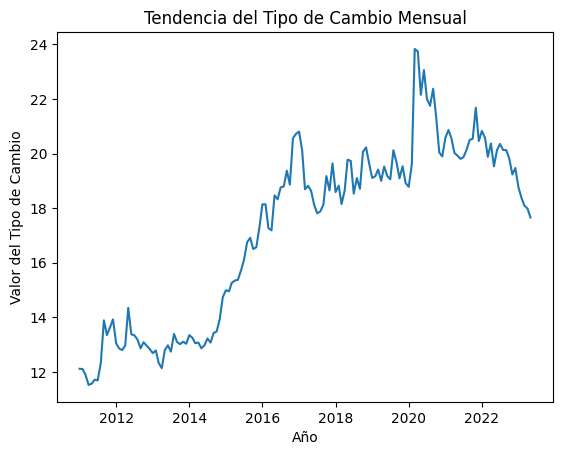

In [57]:
fig, ax = plt.subplots()

ax.plot(TipoCambio['Fecha'], TipoCambio['TC'])
ax.set_title('Tendencia del Tipo de Cambio Mensual')
ax.set_xlabel('Año')
ax.set_ylabel('Valor del Tipo de Cambio')

ax.set_facecolor('none')  # Esto hace el fondo de los ejes transparente

plt.savefig('tipodecambio.png', format = 'png', transparent = True)
plt.show()


# Pruebas de Estacionariedad

In [58]:
pp = PhillipsPerron(TC_log)
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.660
P-value                         0.452
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [59]:
adf = ADF(TC_log)
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.722
P-value                         0.420
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [60]:
kpss = KPSS(TC_log)
print(kpss.summary().as_text())

    KPSS Stationarity Test Results   
Test Statistic                  1.514
P-value                         0.000
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


# Sacar la primera diferencia

In [61]:
D_TC_log = TC_log.diff().dropna()


In [62]:
d_pp = PhillipsPerron(D_TC_log)
print(d_pp.summary().as_text())

d_adf = ADF(D_TC_log)
print(d_adf.summary().as_text())

d_kpss = KPSS(D_TC_log)
print(d_kpss.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -13.276
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                -12.890
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  0.233
P-value                         0.213
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null 

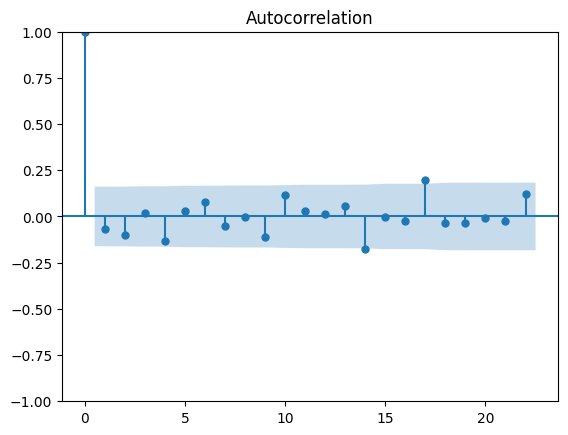

In [63]:
plot_acf(D_TC_log)
plt.savefig('autocorrelacion.png', format = 'png', transparent = True)
plt.show()

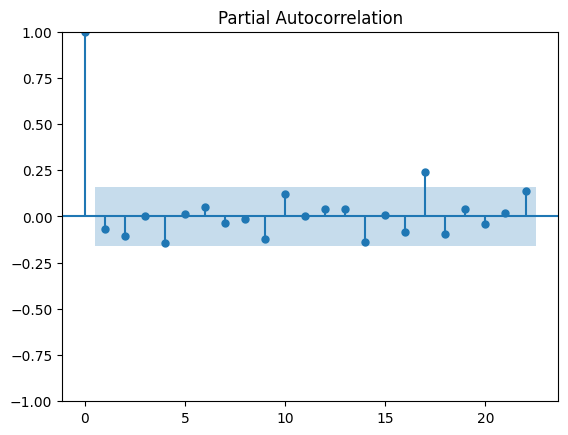

In [64]:
plot_pacf(D_TC_log)
plt.savefig('autocorrelacion parcial.png', format = 'png', transparent = True)
plt.show()

In [65]:
# Modelo ARIMA
model = ARIMA(TC_log, order=(0, 1, 0))  # Necesitas determinar los valores correctos para p, d, q
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                     TC   No. Observations:                  149
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 279.182
Date:                Thu, 15 Jun 2023   AIC                           -556.363
Time:                        00:20:34   BIC                           -553.366
Sample:                             0   HQIC                          -555.145
                                - 149                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0013   8.33e-05     16.162      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):               177.47
Prob(Q):                              0.40   Pr

In [66]:
# Predicciones
predictions = model_fit.predict()

# Prueba de LLUNGBOX

Esta prueba nos permite saber si los residuos son independientes entre sí, si el p-value es mayor a 0.05 podemos suponer que los residuos son independientes

In [67]:
resid = model_fit.resid
print(acorr_ljungbox(resid, lags=[10]))

     lb_stat  lb_pvalue
10  0.505703   0.999993


In [68]:
# Inversión de la transformación logarítmica
predicted_TC = np.exp(predictions)

predicted_TC = predicted_TC[:-1]  # Eliminar el último valor para que tenga la misma longitud que actual_TC

actual_TC = TipoCambio['TC'][1:]


# Cálculo del RMSE
mse = mean_squared_error(actual_TC, predicted_TC)
rmse = sqrt(mse)
print("RMSE:", rmse)

RMSE: 1.2981995175756709


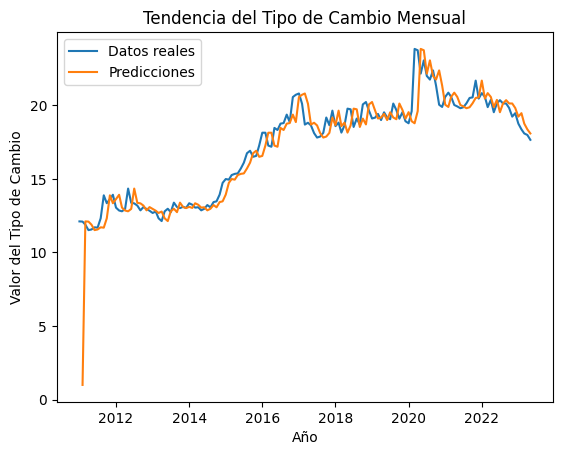

In [69]:
# Gráficas
plt.plot(TipoCambio['Fecha'], TipoCambio['TC'], label='Datos reales')
plt.plot(TipoCambio['Fecha'][1:], predicted_TC, label='Predicciones')
plt.title('Tendencia del Tipo de Cambio Mensual')
plt.xlabel('Año')
plt.ylabel('Valor del Tipo de Cambio')
plt.legend()
plt.savefig('backtesting.png', format = 'png', transparent = True)
plt.show()